In [35]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# Dlnpyutils
from dlnpyutils.utils import bspline,mad,interp

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# functools
from functools import partial

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# pdb
import pdb

# tqdm 
from tqdm.notebook import tqdm

class Aetas():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,star_data,isochrones,ext_law='CCM89',rv=3.1,teff_extrap_limit=100,debug=False):
        
        '''
        Inputs:
        ------
                    star_data: Table (pandas dataframe or astropy table)
                               Observed and calculated properties of a star(s) with the 
                               following columns:
                               
                               'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'FE_H', 'FE_H_ERR',
                               'ALPHA_FE', 'ALPHA_FE_ERR', 'BP', 'G', 'RP', 'J', 'H', 'K',
                               'BP_ERR', 'G_ERR', 'RP_ERR', 'J_ERR', 'H_ERR', 'K_ERR', 
                               'DISTANCE'
                
                               'DISTANCE' must be in units of parsecs
                    
                   isochrones: Table (pandas dataframe or astropy table)
                               PARSEC isochrone table with the following columns:
                               
                               'MH', 'Mass', 'delta_int_IMF', 'logAge', 'logTe', 'logg', 
                               'BPmag', 'Gmag', 'RPmag', 'Jmag', 'Hmag', 'Ksmag', 'label'
                               
                               'delta_int_IMF' is the difference in adjacent 'int_IMF' 
                               values for each isochrone (i.e. int_IMF[i+1]-int_IMF[i])
                               with the last value repeated as the difference returns 
                               one less element.
                               
                               'label' is the evolutionary phase label given by PARSEC
                        
                      ext_law: string, optional
                               extinction law to use. Default is CCM89.

                               Available Extinction Laws: 
                               -------------------------

                               CCM89 - Cardelli, Clayton, & Mathis 1989
                               O94 - O'Donnell 1994
                               F99 - Fitzpatrick 1999
                               F04 - Fitzpatrick 2004
                               VCG04 - Valencic, Clayton, & Gordon 2004
                               GCC09 - Grodon, Cartledge, & Clayton 2009
                               M14 - Maiz Apellaniz et al 2014
                               F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                               D22 - Decleir et al. 2022
                        
                           rv: float, optional
                               Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                               (required to be 3.1 if ext_law = 'F99')
                        
            teff_extrap_limit: float
                               limit for maximum allowable temperature outside 
                               isochrone range that will be extrapolated 
                        
                        debug: bool
                               print useful information to the screen

        '''
        
        # Teff and log(g)
        self.teff = star_data['TEFF'] # temperature
        self.teff_err = star_data['TEFF_ERR'] # temperature error
        self.logg  = star_data['LOGG'] # log(g)
        self.logg_err = star_data['LOGG_ERR'] # log(g) error
        
        # Salaris corrected [Fe/H]
        sal_met = self.salaris_metallicity(star_data['FE_H'],star_data['FE_H_ERR'],
                                           star_data['ALPHA_FE'],star_data['ALPHA_FE_ERR'])
        
        self.salfeh,self.salfeh_err = sal_met[0],sal_met[1]
        
        # observed photometry
        self.obs_phot_labels = ['BP','G','RP','J','H','K']
        self.phot = 999999.0*np.ones(6)
        self.phot_err = 999999.0*np.ones(6)
        for i in range(len(self.phot)):
            self.phot = np.append(self.phot,star_data[self.obs_phot_labels[i]])
            self.phot_err = np.append(self.phot_err,star_data[self.obs_phot_labels[i]+'_ERR'])
        
        # Distance modulus
        self.distmod = 5.0*np.log10(star_data['DISTANCE'])-5.0
        
        # PARSEC isochrones
        self.iso_phot_labels = ['BPmag','Gmag','RPmag','Jmag','Hmag','Ksmag']
        self.iso_interp_labels = ['BPmag','Gmag','RPmag','Jmag','Hmag','Ksmag','logg','delta_int_IMF']
        
        isochrones = isochrones[np.argsort(isochrones['logAge'])]
        
        #pdb.set_trace()
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
                
        # Extinction
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K (microns)
        self.extlaw_coeff = self.extcoeff(law=ext_law,rv=self.rv)
        
        # Other
        self.debug = debug
        self.teff_extrap_limit = teff_extrap_limit 
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value.

        Inputs:
        ------
             data: array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value.

        Inputs:
        ------
              data: array-like
                    data to search through

             value: float or int
                    value of interest

        Output:     
        ------     
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ###################
    ### Metallicity ###
    ###################
    
    def salaris_metallicity(self,metal,metal_err,alpha,alpha_err):
        '''
        Calculate the Salaris corrected metallicity (Salaris et al. 1993) using updated solar 
        parameters from Asplund et al. 2021.
        
        Inputs:
        ------
                 metal: float
                        [Fe/H] of a star
                         
             metal_err: float
                        error in [Fe/H] of a star
                     
                 alpha: float
                        [alpha/Fe] of a star
                 
             alpha_err: float
                        error in [alpha/Fe] of a star
                        
        Outputs:
        -------
                salfeh: float
                        Salaris corrected metallicity
            
            salfeh_err: float
                        error in Salaris corrected metallicity
            
        '''
        salfeh = metal+np.log10(0.659*(10**alpha)+0.341)
        salfeh_err = np.sqrt(metal_err**2+(10**alpha/(0.517372+10**alpha)*alpha_err)**2)
        
        return salfeh, salfeh_err
    
    ##################
    ### Extinction ###
    ##################
    
    def extcoeff(self,law='CCM89',rv=3.1):

        '''
        Calculate the relative extincion law coefficients for the BP, G, RP, J, H, Ks bands
        for a given Rv and extinction law.

        Input:
        -----
                    rv: float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
                        
                   law: str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
        Output:
        ------
             ext_coeff: float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self,label):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and Ks bands
        
        Input:
        -----
            label: int
                   label for PARSEC evolutionary phase
                   
                   Available Labels:
                   ----------------
                   0 = PMS, pre main sequence
                   1 = MS, main sequence
                   2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                   3 = RGB, red giant branch, or the quick stage of red giant for 
                   intermediate+massive stars
                   4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                   intermediate+massive stars
                   5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                   6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                   7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                   massive stars
                   8 = TPAGB, the thermally pulsing asymptotic giant branch
                   9 = post-AGB (in preparation!)
        
        Output:
        ------
              ext: 6x2 array
                   first column is the extinction values and the second is the errors
        '''
        
        if self.debug:
            print('### Running Aetas.extinction() ###')
            print('Inputs from Aetas.__init__()')
            print('Salaris Corrected Metallicity:',self.salfeh)
            print('Temperature:',self.teff)

        # isochrone magnitude labels
        color_labels = np.array([['BPmag','Gmag','Gmag','Gmag','Gmag'],
                                 ['Gmag','RPmag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 500 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.))&
                           (self.iso['label']==label))
        
        iso_ = self.iso[teffcut]
        
        # check to make sure there are enough isochrone points
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones(6)
            self.ext_err = 999999.0*np.ones(6)
            return 999999.0*np.ones(6), 999999.0*np.ones(6)
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        if self.debug:
            print('Calculated Observed Colors:')
            print('Observed Colors:',obs_colors)
            print('Observed Color Errors:',obs_colors_err)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        # relative extinction vector
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        iso_colors = 999999.0*np.ones(5)
        iso_colors_deriv = 999999.0*np.ones(5)
        
        # determine if the Teff is in the isochrone range
        use_lgteff = np.log10(self.teff)
        if use_lgteff < np.min(iso_['logTe']) or use_lgteff > np.max(iso_['logTe']):
            use_lgteff = closest(iso_['logTe'],np.log10(self.teff))
        
        # Interpolate the color-Teff relation using a b-spline
        logTe = iso_['logTe']
        for i in range(5):
            try:
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])

                bspl = bspline(logTe,color)
                iso_colors[i] = bspl(use_lgteff)
                iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    iso_colors[i] = bspl(use_lgteff)
                    iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
                except:
                    iso_colors[i] = 999999.0
                    iso_colors_deriv[i] = 999999.0
                    
        if self.debug:
            print('Isochrone Colors:',iso_colors)
                
        # calculate the extinctions and errors
        color_diff = obs_colors-iso_colors
        color_errs = np.abs((iso_colors_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+color_errs**2)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            if self.debug:
                print('All Colors are bad')
                print('Max Iso Teff:',10**np.nanmax(iso_['logTe']))
                print('Min Iso Teff:',10**np.nanmin(iso_['logTe']))
                print('Obs Teff:',self.teff)
            
            self.ext = 999999.0*np.ones(6)
            self.ext_err = 999999.0*np.ones(6)
            return 999999.0*np.ones(6), 999999.0*np.ones(6)
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        ext = 999999.0*np.ones(6)
        ext_err = 999999.0*np.ones(6)
        ext = ext_vec*ag
        ext_err = ext_vec*ag_err
        
        # chisq
        iso_colors_extincted = iso_colors+red_vec*ag
        ext_chi = sum((obs_colors-iso_colors_extincted)**2/obs_colors_err**2)
        
        self.ext = ext
        self.ext_err = ext_err
        
        if self.debug:
            print('A(G)+ Error:',ag,ag_err)
            print('All Extinctions:',ext[:,0])
            print('chisq:',ext_chi)
            print('resid:',obs_colors-iso_colors_extincted)
        
        return ext, ext_err
    
    ##################################################
    ### Magnitudes, Log(g), Age, Change in int_IMF ###
    ##################################################
    
    def teff_2_appmags_logg(self,teff,age,label,extrap):
        '''
        Calculate the apparent magnitudes and log(g) of a star given its teff and age.
        This function also calculates the change in 'int_IMF' a star woould have, though
        this is not returned, but is stored in self.delta_int_IMF.
        
        Input:
        -----
              teff: float
                    temperature of a star
            
               age: float
                    age in Gyr of a star
            
             label: int
                    label for PARSEC evolutionary phase
                   
                    Available Labels:
                    ----------------
                    0 = PMS, pre main sequence
                    1 = MS, main sequence
                    2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                    3 = RGB, red giant branch, or the quick stage of red giant for 
                    intermediate+massive stars
                    4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                    intermediate+massive stars
                    5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                    6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                    7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                    massive stars
                    8 = TPAGB, the thermally pulsing asymptotic giant branch
                    9 = post-AGB (in preparation!)
                    
            
            extrap: bool
                    False: no extrapolation
                    True: extrapolate
        
        Output:
        ------
             calc_: 7x1 array
                    Calculated apparent magnitudes and log(g) of a star
        
        '''
        
        if self.debug:
            print('Running Aetas.teff_2_appmags()')
            print('Teff:',teff)
            print('Extinctions:',extincts)
        
        # Set up
        lgteff = np.log10(teff)
        lgage = lgage = np.log10(age*10**9)
        
        extincts = self.ext
        
        if extincts[1] > 100.:
            print('Bad extinctions replaced with 0.0')
            extincts *= 0.0
            
        iso = self.iso[np.where(self.iso['label']==label)]
            
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        age_idx = np.asarray(age_idx)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = iso[age_idx[int(aidx)][0]:age_idx[int(aidx)][1]]
            
            ### Teff check
            self.did_extrap = 0

            if (10**min(iso_['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_['logTe']) > self.teff_extrap_limit):
                
                if debug:
                    print('Teff Oustide extrapolation limit')
                    print('Age',age)
                    print('max iso',max(iso_['logTe']))
                    print('min iso',min(iso_['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_['logTe'])-self.teff)
                
                self.delta_int_IMF = 999999.0
                return 999999.0*np.ones(7)
            
            ### use a b-spline to get the apparent mags, log(g), and delta_int_IMF
            calc_ = 999999.0*np.ones(8)
            
            for i in range(len(quantity_labels)):
                
                if extrap:
                    self.did_extrap=1
                    try:
                        spl_ = interp(iso_['logTe'],iso_[self.iso_interp_labels[i]],lgteff,
                                      assume_sorted=False,extrapolate=True)
                        
                        if i <= 5:
                            calc_[i] = spl_+self.distmod+extincts[i]
                    
                    except:
                        calc_[i] = 999999.0
                        
                else:
                    try:
                        spl_ = bspline(iso_['logTe'],iso_[self.iso_interp_labels[i]])(lgteff)
                        
                        if i<= 5:
                            calc_[i] = spl_+self.distmod+extincts[i]
                
                    except:
                        calc_[i] = 999999.0
                    
            self.delta_int_IMF = calc_[-1] # store delta_int_IMF separately
            calc_ = calc_[:-1] # delete int_IMF from the calculated values
            return calc_
        
        else:
            # find 2 closest ages in the ischrones
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if self.debug:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
        
            # younger isochrone
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = iso[age_idx[int(aidx_lo)][0]:age_idx[int(aidx_lo)][1]]
            
            # older isochrone
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = iso[age_idx[int(aidx_hi)][0]:age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            extrap_lo = extrap
            extrap_hi = extrap
            self.did_extrap = 0
                        
            if (10**min(iso_lo['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_lo['logTe']) > self.teff_extrap_limit):
            
                if self.debug:
                    print('outside iso_lo')
                    print('Age',10**lgage_lo/10**9)
                    print('max iso_lo',max(iso_lo['logTe']))
                    print('min iso_lo',min(iso_lo['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_lo['logTe'])-self.teff)
                    
                self.did_extrap = 0
                self.delta_int_IMF = 999999.0
                return 999999.0*np.ones(7)
            
            if (10**min(iso_hi['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_hi['logTe']) > self.teff_extrap_limit):
                if self.debug:
                    print('outside iso_hi')
                    print('max iso_hi',max(iso_hi['logTe']))
                    print('min iso_hi',min(iso_hi['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_hi['logTe'])-self.teff)
                    
                self.delta_int_IMF = 999999.0
                return 999999.0*np.ones(7)
            
            ### use a b-spline to get the apparent mags, log(g), and int_IMF
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_lo = 999999.0*np.ones(8)
            calc_hi = 999999.0*np.ones(8)
            
            for i in range(len(quantity_labels)):
                
                # younger age spline
                if extrap_lo:
                    self.did_extrap=1
                    try:
                        spl_lo = interp(iso_lo['logTe'],iso_lo[self.iso_interp_labels[i]],lgteff,
                                      assume_sorted=False,extrapolate=True)
                        
                        if i <= 5:
                            calc_lo[i] = spl_lo+self.distmod+extincts[i]
                    
                    except:
                        calc_lo[i] = 999999.0
                        
                else:
                    try:
                        spl_lo = bspline(iso_lo['logTe'],iso_lo[self.iso_interp_labels[i]])(lgteff)
                        if i<= 5:
                            calc_lo[i] = spl_lo+self.distmod+extincts[i]
                
                    except:
                        calc_lo[i] = 999999.0
                
                ### older age spline 
                if extrap_hi:
                    self.did_extrap=1
                    try:
                        spl_hi = interp(iso_hi['logTe'],iso_hi[self.iso_interp_labels[i]],lgteff,
                                      assume_sorted=False,extrapolate=True)
                        
                        if i <= 5:
                            calc_hi[i] = spl_hi+self.distmod+extincts[i]
                    
                    except:
                        calc_hi[i] = 999999.0
                        
                else:
                    try:
                        spl_hi = bspline(iso_hi['logTe'],iso_hi[self.iso_interp_labels[i]])(lgteff)
                        
                        if i<= 5:
                            calc_hi[i] = spl_hi+self.distmod+extincts[i]
                
                    except:
                        calc_hi[i] = 999999.0
                    
            calc_ = 999999.0*np.ones(8)        
            for i in range(len(quantity_labels)):
                spl_ = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[calc_lo[i],calc_hi[i]],1)))
                calc_[i] = spl_(age)
             
            self.delta_int_IMF = calc_[-1] # store int_IMF separately
            calc_ = calc_[:-1] # delete int_IMF from the calculated values
            
            return calc_
        
    def get_age(self,guess_ages=np.linspace(0.012,17.)[::10],label=3,extrap=False):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and previously calculated extinction.
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr
            
                 label: int
                        label for PARSEC evolutionary phase
                   
                        Available Labels:
                        ----------------
                        0 = PMS, pre main sequence
                        1 = MS, main sequence
                        2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                        3 = RGB, red giant branch, or the quick stage of red giant for 
                        intermediate+massive stars
                        4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                        intermediate+massive stars
                        5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                        6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                        7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                        massive stars
                        8 = TPAGB, the thermally pulsing asymptotic giant branch
                        9 = post-AGB (in preparation!)
                    
            
                extrap: bool
                        False: no extrapolation
                        True: extrapolate 

            
        Output:
        ------
                   age: float 
                        best age according to chi^2 space search
                        
                   chi: float
                        best chi^2 according to chi^2 space search
                        
                   rms: float
                        RMSE of the result
            
        '''
        
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []
        curve_delta_int_IMF = []
        
        # set photometry error or 0.01 if tiny
        phot_err = np.maximum(self.phot_err,0.01)
        
        if self.debug:
            print('Running Aetas.get_age()')
            print('guess_ages:',guess_ages)

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            try:
                # calculate best fit parameters and covariance matrix
                obs_quants = np.append(np.copy(self.phot),self.logg)
                obs_quants_err = np.append(phot_err,self.logg_err)
                
                teff_2_appmags_ = partial(self.teff_2_appmags,label=label,extrap=extrap)
                popt,pcov = curve_fit(teff_2_appmags_,self.teff,obs_quants,p0=guess_ages[j],
                                      method='lm',sigma=obs_quants_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags_logg = np.asarray(self.teff_2_appmags(self.teff,popt[0],label=label,extrap=extrap))

                if self.debug:
                    print('Calc App Mags + logg:',curve_mags_logg)
                    print('Observed Mags + logg:',obs_quants)
                    print('Observed Mags + logg Errors:',obs_quants_err)
                    

                curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
                curve_rms.append(np.std(curve_mags_logg-obs_quants))

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
                curve_delta_int_IMF.append(999999.0)
                
            if self.debug:
                print(j+1,guess_ages[j],curve_ages[j],curve_chi[j],curve_rms[j])
                
        if np.sum(np.array(curve_ages)<1e5)==0:
            if self.debug:
                print('All Bad')
            return 999999.0, 999999.0, 999999.0
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        delta_int_IMF = np.asarray(curve_delta_int_IMF)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms
        self.delta_int_IMF
        
        if self.debug:
            print('Best Fit Age, chi, RMS:',self.age,self.chi,self.rms)

        return age, chi, rms
    
    def get_weighted_age(self):
        '''
        Calculated age weighted by int_IMF using PARSEC labels 3 and 7
        
        Outputs:
        -------
                  age: float 
                       best age according to chi^2 space search
                        
                  chi: float
                       best chi^2 according to chi^2 space search
                        
                  rms: float
                       RMSE of the result
                        
        delta_int_IMF: float
        '''
        
        ### Find ages and int_IMF for labels 3 and 7
        age_3 = 999999.0
        chi_3 = 999999.0
        rms_3 = 999999.0
        delta_int_IMF_3 = 999999.0
        
        age_3, chi_3, rms_3 = self.get_age(np.linspace(0.012,17.)[::10],3,False)
        delta_int_IMF_3 = self.delta_int_IMF
        
        aage_7 = 999999.0
        chi_7 = 999999.0
        rms_7 = 999999.0
        delta_int_IMF_7 = 999999.0
        
        age_7, chi_7, rms_7 = self.get_age(np.linspace(0.012,17.)[::10],7,False)
        delta_int_IMF_7 = self.delta_int_IMF
        
        min_gyr = 10**np.min(self.iso['logAge'])/10**9
        
        ### If one suceeds inital fitting
        
        if (age_3 < 100. and age_3 > min_gyr) and (age_7 > 100. or age_7 == min_gyr):
            self.age = age_3
            self.chi = chi_3
            self.rms = rms_3
            self.delta_int_IMF = delta_int_IMF_3
            
            return self.age, self.chi, self.rms, self.delta_int_IMF
            
        if (age_3 > 100. or age_3 == min_gyr) and (age_7 < 100. and age_7 > min_gyr):
            self.age = age_7
            self.chi = chi_7
            self.rms = rms_7
            self.delta_int_IMF = delta_int_IMF_7
            
            return self.age, self.chi, self.rms, self.delta_int_IMF
        
        ### If both suceed initial fitting
        
        if (age_3 < 100. and age_3 > min_gyr) and (age_7 < 100. and age_7 > min_gyr):
            
            wgt_age = (delta_int_IMF_3*age_3+delta_int_IMF_7*age_7)/(delta_int_IMF_3+delta_int_IMF_7)
            wgt_chi = (delta_int_IMF_3*chi_3+delta_int_IMF_7*chi_7)/(delta_int_IMF_3+delta_int_IMF_7)
            wgt_rms = (delta_int_IMF_3*rms_3+delta_int_IMF_7*rms_7)/(delta_int_IMF_3+delta_int_IMF_7)
            wgt_delta_int_IMF = ((delta_int_IMF_3*delta_int_IMF_3+delta_int_IMF_7*delta_int_IMF_7)/
                                 (delta_int_IMF_3+delta_int_IMF_7))
            
            self.age = wgt_age
            self.chi = wgt_chi
            self.rms = wgt_rms
            self.delta_int_IMF = wgt_delta_int_IMF
            
            return self.age, self.chi, self.rms, self.delta_int_IMF 
        
        ### If both fail initial fitting
        if (age_3 > 100. and age_7 > 100.) or (age_3==min_gyr and age_7==min_gyr):
            
            age_3 = 999999.0
            chi_3 = 999999.0
            rms_3 = 999999.0
            delta_int_IMF_3 = 999999.0

            age_3, chi_3, rms_3 = self.get_age(np.linspace(0.012,17.)[::10],3,True)
            delta_int_IMF_3 = self.delta_int_IMF

            aage_7 = 999999.0
            chi_7 = 999999.0
            rms_7 = 999999.0
            delta_int_IMF_7 = 999999.0

            age_7, chi_7, rms_7 = self.get_age(np.linspace(0.012,17.)[::10],7,True)
            delta_int_IMF_7 = self.delta_int_IMF
            
            # If one suceeds secondary fitting
            
            if (age_3 < 100. and age_3 > min_gyr) and (age_7 > 100. or age_7 == min_gyr):
                self.age = age_3
                self.chi = chi_3
                self.rms = rms_3
                self.delta_int_IMF = delta_int_IMF_3

                return self.age, self.chi, self.rms, self.delta_int_IMF

            if (age_3 > 100. or age_3 == min_gyr) and (age_7 < 100. and age_7 > min_gyr):
                self.age = age_7
                self.chi = chi_7
                self.rms = rms_7
                self.delta_int_IMF = delta_int_IMF_7

                return self.age, self.chi, self.rms, self.delta_int_IMF
            
            # If both suceed secondary fitting
            
            if (age_3 < 100. and age_3 > min_gyr) and (age_7 < 100. and age_7 > min_gyr):

                wgt_age = (delta_int_IMF_3*age_3+delta_int_IMF_7*age_7)/(delta_int_IMF_3+delta_int_IMF_7)
                wgt_chi = (delta_int_IMF_3*chi_3+delta_int_IMF_7*chi_7)/(delta_int_IMF_3+delta_int_IMF_7)
                wgt_rms = (delta_int_IMF_3*rms_3+delta_int_IMF_7*rms_7)/(delta_int_IMF_3+delta_int_IMF_7)
                wgt_delta_int_IMF = ((delta_int_IMF_3*delta_int_IMF_3+delta_int_IMF_7*delta_int_IMF_7)/
                                     (delta_int_IMF_3+delta_int_IMF_7))

                self.age = wgt_age
                self.chi = wgt_chi
                self.rms = wgt_rms
                self.delta_int_IMF = wgt_delta_int_IMF

                return self.age, self.chi, self.rms, self.delta_int_IMF 
            
            # If both fail secondary fitting
            if (age_3 > 100. and age_7 > 100.) or (age_3==min_gyr and age_7==min_gyr):
                return 999999.0,999999.0,999999.0,999999.0

1. Run Aetas with LEVEL=3 with no extrapolation.  Save best age and delta_INT_IMF

2. Run Aetas with LEVEL=7 only with no extrapolation. Save best age and delta_INT_IMF

3. If both fail, then rerun with extrapolation.

4. if either one succeeds, save the best age and delta_INT_IMF

5. if both succeed, calculate a weighted (with delta_INT_IMF) age, and weighted delta_INT_IMF

weighted delta_int_IMF calculate:

delta_int_IMF = [1,4]
wgted_delta_int_IMF = (1^2+4^2)/(1+4)

if delta_int_IMF is zero use closest

In [8]:
import MagellanicStream as MagellanicStream

def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data:   array-like
                data to search through

        value:  float or int
                value of interest

    Output:
    ------
        close1: float or int
                closest value under the given value

        close2: float or int
                closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC

In [31]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where((massive['label']==3.0)|(massive['label']==7.0))])
massive = massive['MH','Mass','delta_int_IMF','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag','label']

massive['GEDR3mag'].name = 'Gmag'
massive['G_BPEDR3mag'].name = 'BPmag'
massive['G_RPEDR3mag'].name = 'RPmag'

# APOGEE

In [6]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

# diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

# _, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [9]:
from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

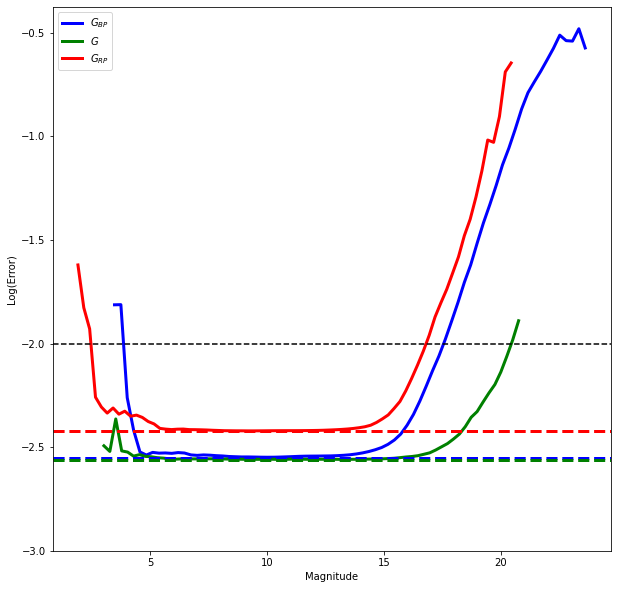

In [10]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Fit the errors
bp_fin = np.where(np.isfinite(bpbin)==True)
g_fin = np.where(np.isfinite(gbin)==True)
rp_fin = np.where(np.isfinite(rpbin)==True)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum)[bp_fin],bpbin[bp_fin])
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum)[g_fin],gbin[g_fin])
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum)[rp_fin],rpbin[rp_fin])

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.axhline(np.log10(0.0027901700),lw=3.0,c='blue',ls='--')
plt.axhline(np.log10(0.0027553202),lw=3.0,c='green',ls='--')
plt.axhline(np.log10(0.0037793818),lw=3.0,c='red',ls='--')
plt.axhline(np.log10(0.01),c='k',ls='--')
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');
# plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight')

<ipython-input-11-c12b4c241cac>:27: RuntimeWarning: divide by zero encountered in log10
  hmaherr = np.log10(allStar['H_ERR'][h_fin])


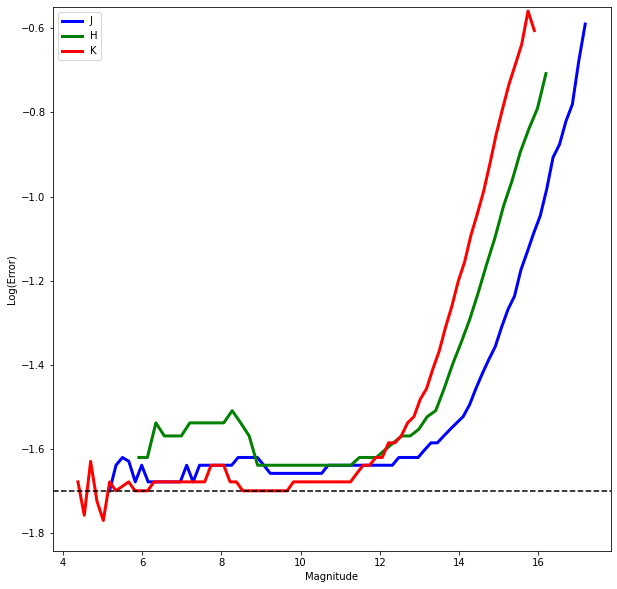

In [11]:
allStar = Table(fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz'))
allStar = allStar['APOGEE_ID','FE_H','FE_H_ERR','J','H','K','J_ERR','H_ERR','K_ERR']

binnum = 75

### J
j_fin = np.where((np.isfinite(allStar['J'])==True)&(allStar['J']<50.)&
                 (np.isfinite(allStar['J_ERR'])==True)&(allStar['J_ERR']<1.))

jmin = min(allStar['J'][j_fin])
jmax = max(allStar['J'][j_fin])

jdiff = jmax-jmin
jmaherr = np.log10(allStar['J_ERR'][j_fin])

jbin ,_,_ = binned_statistic(allStar['J'][j_fin],jmaherr,'median',bins=binnum)
jerrfunc = bspline(np.arange(jmin,jmax,jdiff/binnum),jbin)

### H
h_fin = np.where((np.isfinite(allStar['H'])==True)&(allStar['H']<50.)&
                 (np.isfinite(allStar['H_ERR'])==True)&(allStar['H_ERR']<1.))

hmin = min(allStar['H'][h_fin])
hmax = max(allStar['H'][h_fin])

hdiff = hmax-hmin
hmaherr = np.log10(allStar['H_ERR'][h_fin])

hbin ,_,_ = binned_statistic(allStar['H'][h_fin],hmaherr,'median',bins=binnum)
herrfunc = bspline(np.arange(hmin,hmax,hdiff/binnum),hbin)

### K
k_fin = np.where((np.isfinite(allStar['K'])==True)&(allStar['K']<50.)&
                 (np.isfinite(allStar['K_ERR'])==True)&(allStar['K_ERR']<1.))

kmin = min(allStar['K'][k_fin])
kmax = max(allStar['K'][k_fin])

kdiff = kmax-kmin
kmaherr = np.log10(allStar['K_ERR'][k_fin])

kbin ,_,_ = binned_statistic(allStar['K'][k_fin],kmaherr,'median',bins=binnum)
kerrfunc = bspline(np.arange(kmin,kmax,kdiff/binnum),kbin)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(jmin,jmax,jdiff/binnum),jbin,lw=3.0,c='blue',label=r'J')
plt.plot(np.arange(hmin,hmax,hdiff/binnum),hbin,lw=3.0,c='green',label=r'H')
plt.plot(np.arange(kmin,kmax,kdiff/binnum),kbin,lw=3.0,c='red',label=r'K')
plt.legend()
plt.axhline(np.log10(0.02),c='k',ls='--')
plt.ylim(top=-0.55)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');
# plt.savefig('../plots/2masserrorcurve.pdf',dpi=300,bbox_inches='tight')

### Calculate Errors for NaNs
jerr = 999999.0*np.ones(len(lmcdr17))
herr = 999999.0*np.ones(len(lmcdr17))
kerr = 999999.0*np.ones(len(lmcdr17))

for i in range(len(lmcdr17)):
    if np.isfinite(lmcdr17['J_ERR'][i])==False:
        jerr[i] = 10**jerrfunc(lmcdr17['J'][i])
    else:
        jerr[i] = lmcdr17['J_ERR'][i]
        
    if np.isfinite(lmcdr17['H_ERR'][i])==False:
        herr[i] = 10**herrfunc(lmcdr17['H'][i])
    else:
        herr[i] = lmcdr17['H_ERR'][i]
        
    if np.isfinite(lmcdr17['K_ERR'][i])==False:
        kerr[i] = 10**kerrfunc(lmcdr17['K'][i])
    else:
        kerr[i] = lmcdr17['K_ERR'][i]
        
### Replace nan's with zeropoint error
jerr = np.nan_to_num(jerr,nan=0.02)
herr = np.nan_to_num(herr,nan=0.02)
kerr = np.nan_to_num(kerr,nan=0.02)

In [12]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(lmcdr17['FPARAM'][:,0])+lmcdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(lmcdr17['FPARAM'][:,3])+tcorr

In [27]:
lmc_data = Table(lmcdr17)['TEFF','TEFF_ERR','LOGG','LOGG_ERR','FE_H','FE_H_ERR','GAIAEDR3_PHOT_BP_MEAN_MAG',
                          'GAIAEDR3_PHOT_G_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H','K']

lmc_data['GAIAEDR3_PHOT_G_MEAN_MAG'].name = 'G'
lmc_data['GAIAEDR3_PHOT_RP_MEAN_MAG'].name = 'RP'
lmc_data['GAIAEDR3_PHOT_BP_MEAN_MAG'].name = 'BP'

lmc_data['TEFF'] = teff_cal

lmc_data.add_column(apoafe, name='ALPHA_FE')
lmc_data.add_column(apoafe_err, name='ALPHA_FE_ERR')
lmc_data.add_column(lmcdis*1000, name='DISTANCE')

lmc_data.add_column(jerr, name='J_ERR')
lmc_data.add_column(herr, name='H_ERR')
lmc_data.add_column(kerr, name='K_ERR')

lmc_data.add_column(bperr, name='BP_ERR')
lmc_data.add_column(gerr, name='G_ERR')
lmc_data.add_column(rperr, name='RP_ERR')

In [37]:
# lite = np.arange(len(lmc_data))[::12]

lmc_ext = 999999.0*np.ones((len(lmc_data),6))
lmc_ext_err = 999999.0*np.ones((len(lmc_data),6))
lmc_age = 999999.0*np.ones(len(lmc_data))
lmc_chi = 999999.0*np.ones(len(lmc_data))
lmc_rms = 999999.0*np.ones(len(lmc_data))
lmc_delta_int_IMF = 999999.0*np.ones(len(lmc_data))
# lmc_mass = 999999.0*np.ones(len(lmc_data))

for i in tqdm(range(len(lmc_data))):

    CalcAge = Aetas(lmc_data[i],massive,teff_extrap_limit=200)
    
    lmc_ext[i,:],lmc_ext_err[i,:] = CalcAge.extinction(label=3)
    lmc_age[i],lmc_chi[i],lmc_rms[i],lmc_delta_int_IMF[i] = CalcAge.get_weighted_age()
#     lmc_mass[i] = CalcAge.age_2_mass(lmc_age[i])

  0%|          | 0/6130 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (11,) (5,) 